## Extraer tablas de la seccion 1

Se importan las librerías generales que se utilizarían, además de los documentos CSV creados en el paso anterior

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#Csv importaciones
Sales_Time_ATTR = pd.read_csv("Sales_Time_ATTR.csv")
Sales_Time_ATTR.head()

,WEEK,ITEM,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES,TOTAL_UNIT_AVG_WEEKLY_SALES,REGION,YEAR,MONTH,WEEK_NUMBER,DATE,CLORO,FABRIC TREATMENT
0,34-22,7501058792808BP2,0.006,0.139,1.000,TOTAL AUTOS AREA 5,2022,8,34,2022-08-28,False,True
1,34-22,7501058715883,0.487,116.519,2.916,TOTAL AUTOS AREA 5,2022,8,34,2022-08-28,False,True
2,34-22,7702626213774,1.391,68.453,5.171,TOTAL AUTOS AREA 5,2022,8,34,2022-08-28,False,True
3,34-22,7501058716422,0.022,1.481,1.833,TOTAL AUTOS AREA 5,2022,8,34,2022-08-28,False,True
4,34-22,7501058784353,2.037,182.839,5.375,TOTAL AUTOS AREA 5,2022,8,34,2022-08-28,False,True


In [2]:
# Ver las regiones en las que esta dividido
Sales_Time_ATTR["REGION"].unique()

array(['TOTAL AUTOS AREA 5', 'TOTAL AUTOS AREA 6',
       'TOTAL AUTOS SCANNING MEXICO', 'TOTAL AUTOS AREA 3',
       'TOTAL AUTOS AREA 2', 'TOTAL AUTOS AREA 1', 'TOTAL AUTOS AREA 4'],
      dtype=object)

## Crear tablas para la región según la área para un posible análisis independientes en cada área.

In [3]:
Sales_Time_ATTR_A1 = Sales_Time_ATTR[Sales_Time_ATTR["REGION"] == "TOTAL AUTOS AREA 1"]
Sales_Time_ATTR_A2 = Sales_Time_ATTR[Sales_Time_ATTR["REGION"] == "TOTAL AUTOS AREA 2"]
Sales_Time_ATTR_A3 = Sales_Time_ATTR[Sales_Time_ATTR["REGION"] == "TOTAL AUTOS AREA 3"]
Sales_Time_ATTR_A4 = Sales_Time_ATTR[Sales_Time_ATTR["REGION"] == "TOTAL AUTOS AREA 4"]
Sales_Time_ATTR_A5 = Sales_Time_ATTR[Sales_Time_ATTR["REGION"] == "TOTAL AUTOS AREA 5"]
Sales_Time_ATTR_A6 = Sales_Time_ATTR[Sales_Time_ATTR["REGION"] == "TOTAL AUTOS AREA 6"]

Sales_Time_ATTR_AM = Sales_Time_ATTR[Sales_Time_ATTR["REGION"] == "TOTAL AUTOS SCANNING MEXICO"]

## Definicion del medole de entrenamiento

### Generar Funciones que se utilizaran en este modelo.

Se pueden editar ligeramente para definir tanto tolerancio o diferentes caracteristicas del modelo

In [4]:
# Creacion de data frame con serie de fechas mensuales (Time Unit Sales)
def TUS_DF (df):
    STA = df.groupby(["YEAR", "MONTH"])["TOTAL_UNIT_SALES"].sum()
    STA  = pd.DataFrame(STA)

    YY = str(STA.index[0][0])
    MM = YR = str(STA.index[0][1])

    Start_date = YY + "-" + MM + "-01"

    monthly_dates = pd.date_range(start=Start_date, periods=len(STA), freq='MS')
    STA["Fechas"] = monthly_dates
    STA = STA.reset_index()
    STA.set_index("Fechas", drop=True, inplace= True)
    STA.index = pd.DatetimeIndex(STA.index.values,
                               freq=STA.index.inferred_freq)
    return STA


In [5]:
def Tamano_train_Series (df_Original, tamano_entrenamiento = 0.80):
    # Tamaño de muestra
    len_train = int(len(df_Original) * tamano_entrenamiento)
    
    # Definición de grupos de prueba y entrenamiento
    Train = df_Original[0:len_train]
    Test = df_Original[len_train:]

    return Train, Test

In [6]:
def Autoco_data_plot (df_Basico, alpha_Seleccionado = 0.9):
    from statsmodels.tsa.stattools import acf
    from statsmodels.graphics.tsaplots import plot_acf
    import matplotlib.pyplot as plt
    
    # Generacion de la funcion de autocorrelacion
    acf_array = acf(df_Basico)
    print(acf_array)
    
    # Gráfico con un nivel de confianza del 90%
    plot_acf(df_Basico, alpha = alpha_Seleccionado)
    plt.show()
    

In [7]:
def Busqueda_ARIMA_AIC_Optimo (df_Analizar, Max_P = 3, Max_D = 3, Max_Q = 3):
    from statsmodels.tsa.arima.model import ARIMA
    
    best_AIC = np.inf
    best_order = None

    #En caso de que el index ocn fechas no tenga establecida la frecuencia
    #df_Analizar.index = pd.DatetimeIndex(df_Analizar.index.values,
    #                           freq=df_Analizar.index.inferred_freq)
    
    # Rango de valores para p, d, q
    p_values = range(0, Max_P)
    d_values = range(0, Max_D)
    q_values = range(0, Max_Q)

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(df_Analizar , order=(p,d,q))
                    results = model.fit()
                    # print(f"ARIMA Order: {(p,d,q)} con Akaike (AIC): {results.aic}")
                    if results.aic < best_AIC:
                        best_AIC = results.aic
                        best_order = (p,d,q)
                except:
                    continue
    return best_order, best_AIC

In [8]:
def MAPEyRMSE (df_Test, Periodos_Posteriores = 6, conf_alpha = 0.05):
    # Pronostico
    
    predicciones = results.forecast(len(df_Test) + Periodos_Posteriores)
    predicciones = pd.DataFrame(predicciones)
    predicciones = predicciones.reset_index()
    
    # Confianza
    conf = results.get_forecast(len(df_Test) + Periodos_Posteriores).conf_int(alpha = conf_alpha)
    #conf = conf.reset_index()
    Test = df_Test[["TOTAL_UNIT_SALES"]]
    
    acumulador1 = 0
    acumulador2 = 0
    
    for contador in range(0,len(Test)):
        acumulador1 = acumulador1 + (Test.iloc[contador] - predicciones.iloc[contador, 1]) ** 2
        acumulador2 = acumulador2 + np.abs((Test.iloc[contador] - predicciones.iloc[contador,1])/
                                        Test.iloc[contador])
    mse = acumulador1 / len(Test)
    rmse = np.round(np.sqrt(mse), 2)
    mape = np.round((acumulador2 / len(Test)) * 100, 2)

    #print("RMSE = ", float(rmse), "\nMAPE = ", float(mape), "%")
    predicciones.set_index("index", drop=True, inplace= True)
    
    return float(mape), float(rmse), predicciones, conf

In [9]:
def grafica_Test_Pronostico_prediccion(Train, Test, Predicciones, Confianza, Order):
    import matplotlib.pyplot as plt
    plt.figure(figsize = (20,5))
    plt.grid()
    plt.plot(Train, label = "Train")
    plt.plot(Test,  label = "Test")
    plt.plot(Predicciones, label = "Predicciones", color = "red")
    plt.plot(Confianza["lower TOTAL_UNIT_SALES"], label = "Lim. Inf. 95 %", color = "blue")
    plt.plot(Confianza["upper TOTAL_UNIT_SALES"], label = "Lim. Sup. 95 %", color = "blue")
    plt.legend(loc = "best")
    plt.title(f"Pronostico mediante ARIMA{Order}")

## En el siguiente bloque de codigo puedes cambiar a los datos por segion en la copia y todo el modelo se adaptara para analizar esa region en particular

In [10]:
# Aqui puedes cambiar a los datos por segion en la copia y todo el modelo se adaptara para analizar esa region en particular
DF_A_Analizar = Sales_Time_ATTR_AM.copy()

## Inicio del modelado

Autocorrelacion CLORO: 
[ 1.          0.25434539  0.05094097  0.00957808 -0.03384781 -0.12501378
  0.00281467 -0.2618534  -0.18221349  0.02371352 -0.08440694  0.00259092]


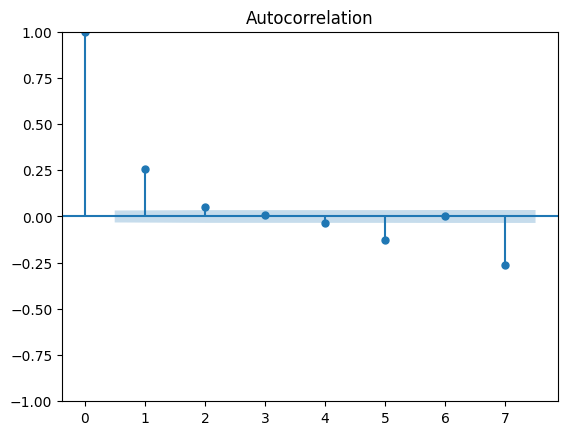


Autocorrelacion FABRIC TREATMENT: 
[ 1.         -0.24505739 -0.13103996 -0.08946484 -0.00514216 -0.05264154
  0.02850883 -0.19247805  0.04224655  0.24320533  0.01193833 -0.11228338]


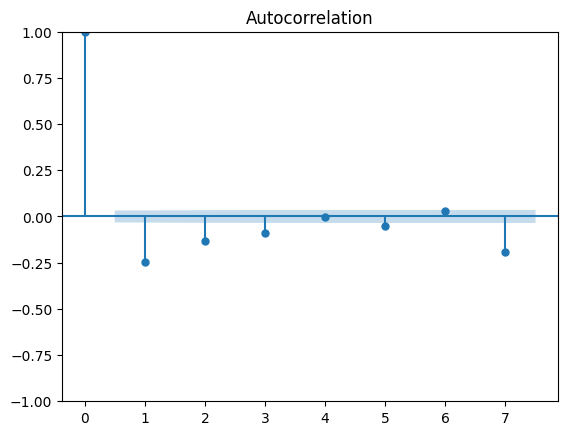

In [11]:
# Select ATTR (Sales Total Atribute _ Cloro)
STA_C= TUS_DF(DF_A_Analizar[DF_A_Analizar["CLORO"]])
STA_FT= TUS_DF(DF_A_Analizar[DF_A_Analizar["FABRIC TREATMENT"]])

# Train data Selection
STA_C_Train, STA_C_Test = Tamano_train_Series(STA_C)
STA_FT_Train, STA_FT_Test = Tamano_train_Series(STA_FT)

# Grafica Auto correlacion
print("Autocorrelacion CLORO: ")
Autoco_data_plot(STA_C_Train[["TOTAL_UNIT_SALES"]])

print("\nAutocorrelacion FABRIC TREATMENT: ")
Autoco_data_plot(STA_FT_Train[["TOTAL_UNIT_SALES"]])

## Modelo para prediccion del ClORO

Modelo seleccionado Para prediccion del Cloro
Mejor ARIMA Order: (0, 2, 1) con AIC: 229.32053958995462
RMSE =  1934.54 
MAPE =  16.73 %


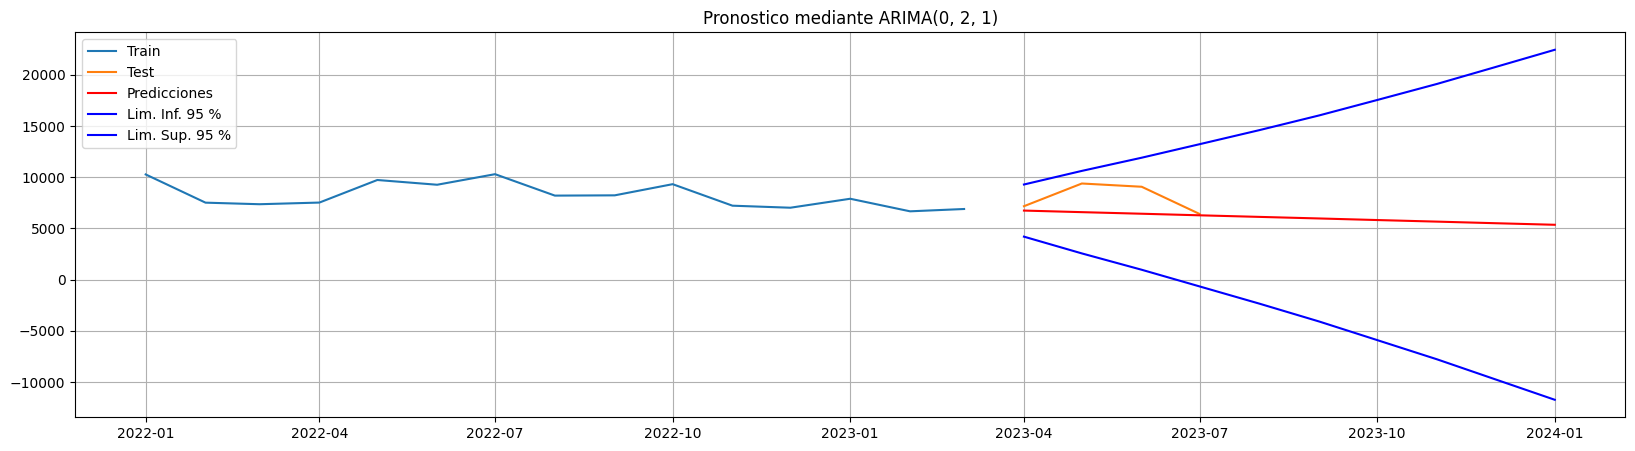

In [12]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore") 

Order_Select, BEST_AIC = Busqueda_ARIMA_AIC_Optimo(STA_C_Train[["TOTAL_UNIT_SALES"]])
model = ARIMA(STA_C_Train[["TOTAL_UNIT_SALES"]] , order=Order_Select)
results = model.fit()

print("Modelo seleccionado Para prediccion del Cloro")
print(f"Mejor ARIMA Order: {Order_Select} con AIC: {BEST_AIC}")

MAPE, RMSE, Predicciones, Confianza = MAPEyRMSE(STA_C_Test)
print("RMSE = ", RMSE, "\nMAPE = ", MAPE, "%")

TRAIN_df = STA_C_Train[["TOTAL_UNIT_SALES"]]
TEST_df = STA_C_Test[["TOTAL_UNIT_SALES"]]
grafica_Test_Pronostico_prediccion(TRAIN_df, TEST_df, Predicciones, Confianza, Order_Select)

Este modelo de predicción tiene una precisión bastante elevada, solo que no es muy recomendable debido a la variabilidad en las predicciones. Para cerciorarse previamente se intentó con más modelos y distintos valores con inclusive un AIC mayor, pero estos generaban un sobre ajuste haciendo que el modelo predicho tuviera una precisión de menos del 65%. Con esto dicho la predicción es decente pero sería recomendable incrementar el tamaño de muestra para mejorar el modelo.

## Modelo para prediccion del FABRIC TREATMENT

Modelo seleccionado Para prediccion del FABRIC TREATMENT
Mejor ARIMA Order: (0, 2, 2) con AIC: 190.023241624748
RMSE =  314.61 
MAPE =  14.93 %


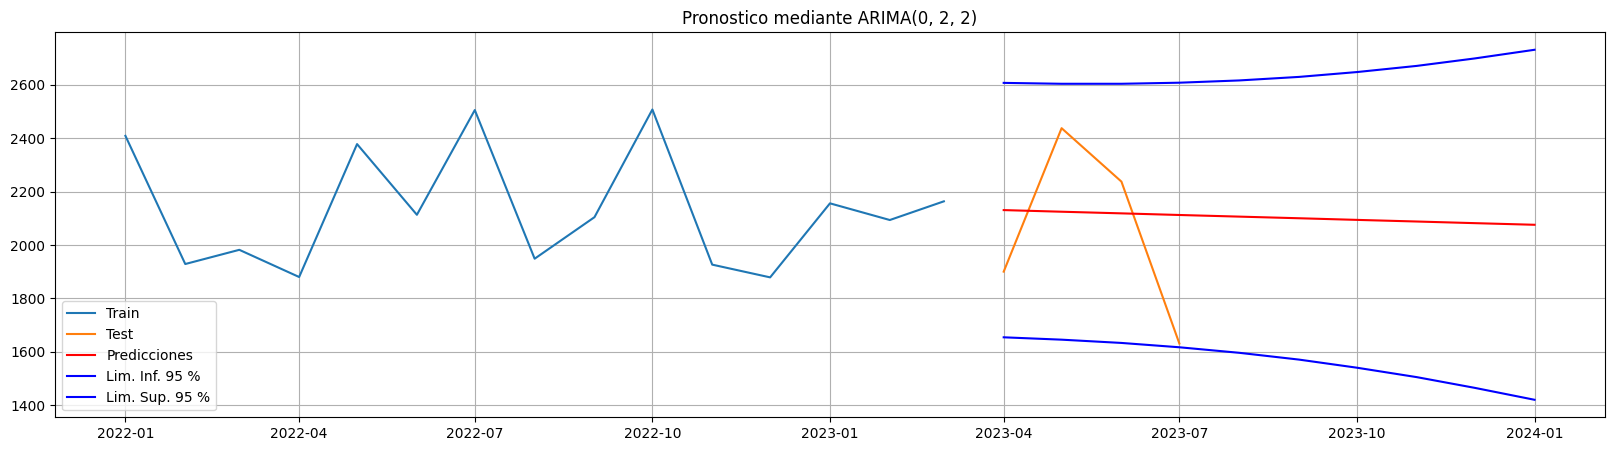

In [13]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore") 

Order_Select, BEST_AIC = Busqueda_ARIMA_AIC_Optimo(STA_FT_Train[["TOTAL_UNIT_SALES"]])
model = ARIMA(STA_FT_Train[["TOTAL_UNIT_SALES"]] , order=Order_Select)
results = model.fit()

print("Modelo seleccionado Para prediccion del FABRIC TREATMENT")
print(f"Mejor ARIMA Order: {Order_Select} con AIC: {BEST_AIC}")

MAPE, RMSE, Predicciones, Confianza = MAPEyRMSE(STA_FT_Test)
print("RMSE = ", RMSE, "\nMAPE = ", MAPE, "%")

TRAIN_df = STA_FT_Train[["TOTAL_UNIT_SALES"]]
TEST_df = STA_FT_Test[["TOTAL_UNIT_SALES"]]
grafica_Test_Pronostico_prediccion(TRAIN_df, TEST_df, Predicciones, Confianza, Order_Select)

El modelo de FABRIC tiene una buena predicción, que aunque no predice con exactitud los futuros valores este muestra un estándar general de valores a lo largo del tiempo. Con una media de error absoluto del 14.93% este modelo es utilizable, pero sería mejor tratar con distintos métodos para disminuir este error a menos del 10%.

### Graficacion de los modelos

Correlacion de ventas entre productos de atributos CLORO y FABRIC TREATMENT 
 0.8434530986798362


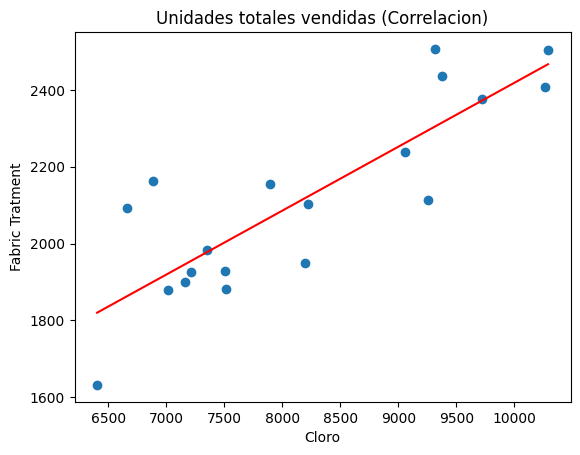

In [14]:
X = STA_C['TOTAL_UNIT_SALES']
Y = STA_FT['TOTAL_UNIT_SALES']
correlation = X.corr(Y)
print("Correlacion de ventas entre productos de atributos CLORO y FABRIC TREATMENT \n",float(correlation))

# Grafica para dar una representacion visual
plt.scatter(X, Y)
plt.title("Unidades totales vendidas (Correlacion)")
plt.xlabel("Cloro")
plt.ylabel("Fabric Tratment")

# This will fit the best line into the graph
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))
         (np.unique(X)), color='red')

plt.show()

Al hacer una comparación en las ventas de Cloro y Fabric treatment a ambos estar relacionados en ámbitos textiles se puede comprender que tienen una correlación lineal bastante elevada y con este análisis sería del 84.34%

## Conclusión

Los análisis de Fabric (Telas) y cloro mostraron ser los atributos que más se repetían, por lo cual se eligieron para hacer una comparativa entre ellos.

Al revisar la autocorrelación si se analizan tanto la Fabric como el Cloro se puede ver que tiene una auto-Correlación estadísticamente menos significativa durante los mismos periodos.

Cuando se hizo una serie de tiempos en ambos Atributos se pudo observar que estar poseen una gran cantidad de variaciones y que aunque satisfactorio los modelos aun requerirían optimizarse para poder ser utilizados para predicciones futuras pero permite hacer una análisis de comportamientos y características que afectaron en el pasado y pueden influenciar el producto.

Por último para cerciorarnos se hizo una prueba de correlación debido a que al comparar ambas gráficas de manera visual se observó cómo presentaban un comportamiento muy similar (aunque no los mismos valores) durante varios periodos, dando como resultado que tiene una Auto-correlación bastante elevada.